<a href="https://colab.research.google.com/github/vineeth995/ThesisScripts/blob/main/RandomForest_without_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
!pip install shap
!pip install eli5
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 5000)
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.inspection import permutation_importance
import eli5
import pickle

     |████████████████████████████████| 358kB 13.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=6d6ff87d570754c95f7ba902479c977d8c3a8e40747f0641261aa539a7fa4026
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 112kB 14.9MB/s 


The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv("/content/drive/My Drive/House_Prices/immo_data.csv")

Mounted at /content/drive


In [ ]:
data_cat=pd.read_csv("/content/drive/My Drive/House_Prices/immo_data.csv")

# New Section
Data Preprocessing and Model Fitting

In [ ]:

data_cat=data_cat.drop(['telekomHybridUploadSpeed','picturecount','scoutId','noParkSpaces','date','electricityKwhPrice','electricityBasePrice','description','street','streetPlain','houseNumber','telekomTvOffer','telekomUploadSpeed','lastRefurbish','energyEfficiencyClass','heatingCosts','regio3','facilities'
,'livingSpaceRange','noRoomsRange','baseRentRange','thermalChar','petsAllowed','geo_bln','geo_krs','serviceCharge','pricetrend','totalRent','yearConstructedRange','yearConstructed','firingTypes','regio1','regio2','numberOfFloors'],axis=1)
data_cat = data_cat.dropna(subset=['heatingType','newlyConst','balcony','hasKitchen','cellar','baseRent','livingSpace','condition','interiorQual','lift','typeOfFlat','geo_plz','noRooms','floor','garden'],inplace=False)

In [ ]:
data_cat.head(10)

,heatingType,newlyConst,balcony,hasKitchen,cellar,baseRent,livingSpace,condition,interiorQual,lift,typeOfFlat,geo_plz,noRooms,floor,garden
0,central_heating,False,False,False,True,595.00,86.00,well_kept,normal,False,ground_floor,44269,4.0,1.0,True
2,floor_heating,True,True,False,True,965.00,83.80,first_time_use,sophisticated,True,apartment,1097,3.0,3.0,False
8,oil_heating,False,False,True,True,580.00,53.00,well_kept,sophisticated,False,roof_storey,79211,2.0,2.0,False
9,self_contained_central_heating,False,False,False,True,300.00,60.00,well_kept,normal,False,apartment,45888,2.5,2.0,False
13,central_heating,False,False,False,False,950.00,123.44,first_time_use_after_refurbishment,sophisticated,False,apartment,59065,4.0,4.0,False
14,gas_heating,True,True,False,True,972.60,87.00,first_time_use,sophisticated,True,ground_floor,44229,3.0,0.0,False
17,central_heating,False,False,False,False,200.00,50.00,refurbished,normal,False,roof_storey,4720,2.0,3.0,True
19,district_heating,False,True,False,True,1343.48,127.95,mint_condition,sophisticated,True,apartment,37073,5.0,1.0,False
20,central_heating,False,True,False,True,1150.00,160.00,well_kept,sophisticated,False,ground_floor,24539,4.0,0.0,True
24,central_heating,False,True,False,True,620.00,55.89,fully_renovated,normal,False,apartment,22111,3.0,2.0,False


In [ ]:
#Run if you want encoding
#dont use for catboost
lbl_enc = LabelEncoder()
data_cat.loc[:, "heatingType"] = lbl_enc.fit_transform(data_cat.heatingType.values)
data_cat.loc[:, "condition"] = lbl_enc.fit_transform(data_cat.condition.values)
data_cat.loc[:, "interiorQual"] = lbl_enc.fit_transform(data_cat.interiorQual.values)
data_cat.loc[:, "typeOfFlat"] = lbl_enc.fit_transform(data_cat.typeOfFlat.values)
data_cat.loc[:, "geo_plz"] = lbl_enc.fit_transform(data_cat.geo_plz.values)

In [ ]:
#if you want to encode enum values
def balkon(row):
    if row['balcony']==True:
        return 1
    elif row['balcony']==False:
        return 0    
    
def kitchen(row):
    if row['hasKitchen']==True:
        return 1
    elif row['hasKitchen']==False:
        return 0    
    
def cellar(row):
    if row['cellar']==True:
        return 1
    elif row['cellar']==False:
        return 0    
 
def lift(row):
    if row['lift']==True:
        return 1
    elif row['lift']==False:
        return 0

def garden(row):
    if row['garden']==True:
        return 1
    elif row['garden']==False:
        return 0 

def newlyConst(row):
    if row['newlyConst']==True:
      return 1
    else: 
      return 0  

data_cat['balcony']=data_cat.apply(lambda row: balkon(row),axis=1)
data_cat['hasKitchen']=data_cat.apply(lambda row: kitchen(row),axis=1)
data_cat['cellar']=data_cat.apply(lambda row: cellar(row),axis=1)
data_cat['lift']=data_cat.apply(lambda row: lift(row),axis=1)
data_cat['garden']=data_cat.apply(lambda row: garden(row),axis=1)
data_cat['newlyConst']=data_cat.apply(lambda row: newlyConst(row),axis=1)   

#data_cat['balcony'] = data_cat.noRooms.astype('int')
#data_cat['balcony'] = data_cat.floor.astype('category')
#data_cat['hasKitchen'] = data_cat.noRooms.astype('int')
#data_cat['hasKitchen'] = data_cat.floor.astype('category')
#data_cat['cellar'] = data_cat.noRooms.astype('int')
#data_cat['cellar'] = data_cat.floor.astype('category')
#data_cat['lift'] = data_cat.noRooms.astype('int')
#data_cat['lift'] = data_cat.floor.astype('category')
#data_cat['garden'] = data_cat.noRooms.astype('int')
#data_cat['garden'] = data_cat.floor.astype('category')
#data_cat['newlyConst'] = data_cat.noRooms.astype('int')
#data_cat['newlyConst'] = data_cat.floor.astype('category')

In [ ]:
#trimming extreme values
data_cat.drop(data_cat[(data_cat['baseRent'] > 8000) | (data_cat['baseRent'] < 100)].index, inplace = True ,axis = 0)
data_cat.drop(data_cat[(data_cat['livingSpace'] >= 2420) | (data_cat['livingSpace'] < 10)].index, inplace = True, axis = 0)
data_cat.drop(data_cat[(data_cat['livingSpace'] < 100) & (data_cat['baseRent'] > 4000)].index, inplace = True, axis = 0)
data_cat.drop(data_cat[(data_cat['noRooms'] > 15)].index, inplace = True, axis = 0)

In [ ]:
#setting floors as category 
data_cat['noRooms'] = data_cat.noRooms.astype('int')
data_cat['floor'] = data_cat.floor.astype('int')
data_cat['floor'] = data_cat.floor.astype('category')

In [ ]:
#splitting X and y variables
y_cat=data_cat['baseRent']
X_cat=data_cat.drop(['baseRent'],axis=1)

In [ ]:
#splitting into testing and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cat, y_cat)

In [ ]:
rf = RandomForestRegressor(random_state=42,)

In [ ]:
params = rf.get_params()
for key,value in params.items():
    print("%s : %s" %(key, value))

bootstrap : True
ccp_alpha : 0.0
criterion : mse
max_depth : None
max_features : auto
max_leaf_nodes : None
max_samples : None
min_impurity_decrease : 0.0
min_impurity_split : None
min_samples_leaf : 1
min_samples_split : 2
min_weight_fraction_leaf : 0.0
n_estimators : 100
n_jobs : None
oob_score : False
random_state : 42
verbose : 0
warm_start : False


In [ ]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
pkl_filename = "rf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf, file)

In [ ]:
y_calc=rf.predict(X_train)
r2_score(y_train,y_calc)

0.8881046248465256

In [ ]:
mean_squared_error(y_train,y_calc)

36317.45527175629

In [ ]:
mean_absolute_error(y_train,y_calc)

104.00947542119378

In [ ]:
y_calc=rf.predict(X_test)
r2_score(y_test,y_calc)

0.8288701599444901

In [ ]:
mean_squared_error(y_test,y_calc)

47654.79820860196

In [ ]:
mean_absolute_error(y_test,y_calc)

125.02350409616905

In [ ]:
parameters = {
                  
                  'n_estimators' : [50,100,500,1000],
                  #'max_depth'    : [4,6,8,10],
                  #'min_samples_split' : [2,4,6],
                  'min_samples_leaf': [1,3,7],
                  'max_depth' : range(5,15)
              
                 }

In [ ]:
grid_RF = RandomizedSearchCV(estimator=rf, param_distributions = parameters, cv = 2, n_jobs=-1)
grid_RF.fit(X_train, y_train)

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

# Random Forest Feature Importance

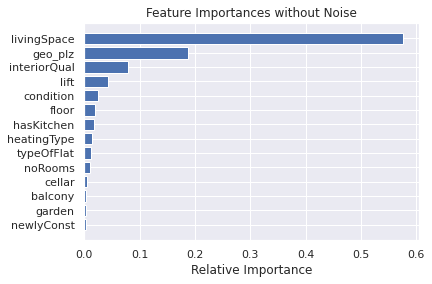

In [ ]:
%matplotlib inline
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
sns.set()
plt.title('Feature Importances without Noise')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


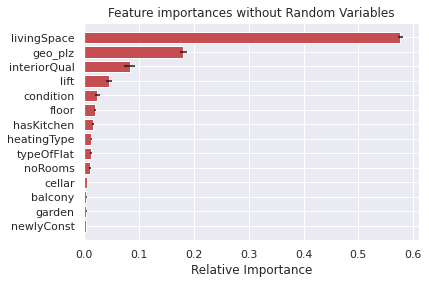

In [ ]:
importances = rf.feature_importances_
features = X_train.columns
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances without Random Variables")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, X_train.shape[1]])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
FI=[features[i] for i in indices]

In [ ]:
FI.reverse()

In [ ]:
FI[0:7]

['livingSpace',
 'geo_plz',
 'interiorQual',
 'lift',
 'condition',
 'floor',
 'hasKitchen']

In [ ]:
FI = FI[0:6]

In [ ]:
FI

['livingSpace',
 'geo_plz',
 'condition',
 'interiorQual',
 'newlyConst',
 'noRooms']

In [ ]:
importances= importances.sort()

In [ ]:
importances

In [ ]:
plt.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X_train.columns[perm_sorted_idx])
plt.show()

# Random Forest Permutation Importance

In [ ]:
result = permutation_importance(rf, X_test[1:100], y_test[1:100],n_repeats=30,random_state=0)

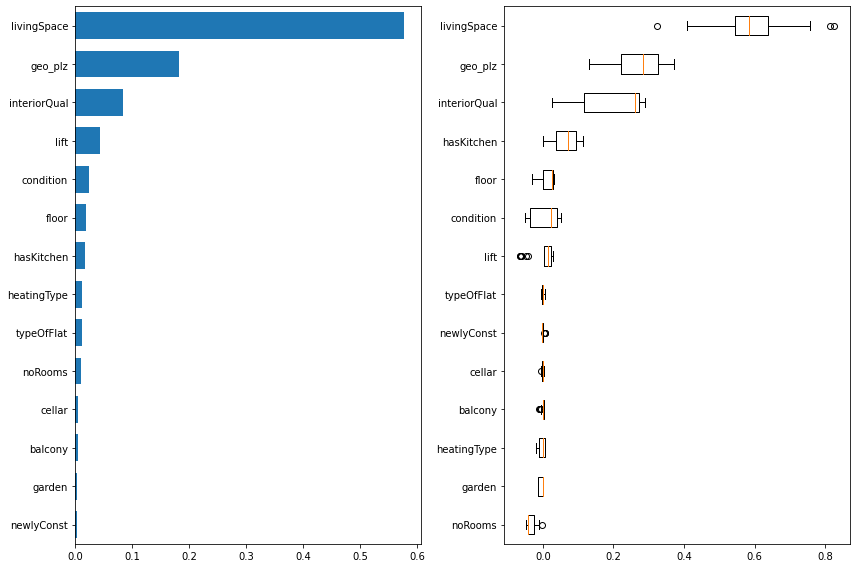

In [ ]:
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[perm_sorted_idx])
fig.tight_layout()
plt.show()

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=1).fit(X_train, y_train)
#eli5.show_weights(perm, feature_names = X_train.columns.tolist())

In [ ]:
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.8068 ± 0.0107,livingSpace
0.3725 ± 0.0017,geo_plz
0.1531 ± 0.0048,interiorQual
0.0792 ± 0.0034,lift
0.0541 ± 0.0007,hasKitchen
0.0463 ± 0.0007,condition
0.0272 ± 0.0008,floor
0.0162 ± 0.0005,heatingType
0.0153 ± 0.0007,typeOfFlat
0.0140 ± 0.0003,noRooms


In [ ]:
w = eli5.show_weights(perm, feature_names=X_train.columns.tolist())
result = pd.read_html(w.data)[0]
result

,Weight,Feature
0,0.8068 ± 0.0107,livingSpace
1,0.3725 ± 0.0017,geo_plz
2,0.1531 ± 0.0048,interiorQual
3,0.0792 ± 0.0034,lift
4,0.0541 ± 0.0007,hasKitchen
5,0.0463 ± 0.0007,condition
6,0.0272 ± 0.0008,floor
7,0.0162 ± 0.0005,heatingType
8,0.0153 ± 0.0007,typeOfFlat
9,0.0140 ± 0.0003,noRooms


In [ ]:
result['wt']=result['Weight'].apply(lambda x:float(x.split(' ')[0]))

In [ ]:
sns.set()

In [ ]:
result

,Weight,Feature,wt
0,0.8068 ± 0.0107,livingSpace,0.8068
1,0.3725 ± 0.0017,geo_plz,0.3725
2,0.1531 ± 0.0048,interiorQual,0.1531
3,0.0792 ± 0.0034,lift,0.0792
4,0.0541 ± 0.0007,hasKitchen,0.0541
5,0.0463 ± 0.0007,condition,0.0463
6,0.0272 ± 0.0008,floor,0.0272
7,0.0162 ± 0.0005,heatingType,0.0162
8,0.0153 ± 0.0007,typeOfFlat,0.0153
9,0.0140 ± 0.0003,noRooms,0.0140


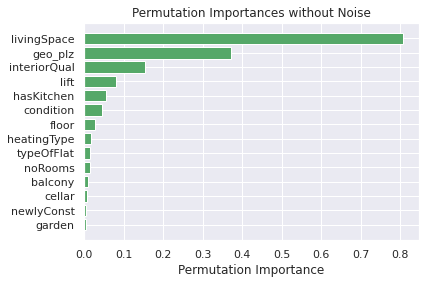

In [ ]:
plt.title('Permutation Importances without Noise')
plt.barh(result['Feature'], result['wt'], color='g', align='center')
#plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Permutation Importance')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
arr=result['Weight'].values
arrs= arr[0].split(' ')[0]
float(arrs)

0.8123

In [ ]:
a=result['Feature'].head(7)
PFI=a.to_list()

In [ ]:
PFI

['livingSpace',
 'geo_plz',
 'interiorQual',
 'lift',
 'hasKitchen',
 'condition',
 'floor']

In [ ]:
t= type(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))

In [ ]:
X_train.dtypes

heatingType        int64
newlyConst         int64
balcony            int64
hasKitchen         int64
cellar             int64
livingSpace      float64
condition          int64
interiorQual       int64
lift               int64
typeOfFlat         int64
geo_plz            int64
noRooms            int64
floor           category
garden             int64
dtype: object

# Random Forest Shapley Values

In [ ]:
shap.initjs()
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_train[1:30000])

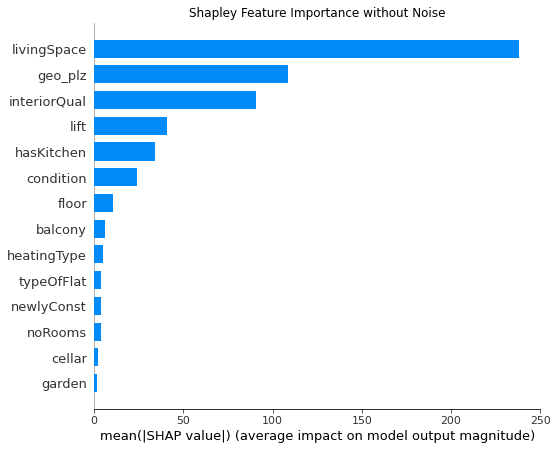

In [ ]:
%matplotlib inline
shap.initjs()
plt.title('Shapley Feature Importance without Noise')
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

In [ ]:
result =X_train[(X_train.livingSpace == 33) & (X_train.geo_plz == 3699)]
x=X_train.index.get_loc(result.iloc[0].name)


16016

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value, shap_values_rf[x,:], X_train.iloc[x,:])

In [ ]:
result =data_cat[(data_cat.livingSpace == 33) & (data_cat.geo_plz == 3699)]
data_cat.index.get_loc(result.iloc[0].name)

13507

In [ ]:
shap_sum = np.abs(shap_values_rf).mean(axis=0)
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
5,livingSpace,235.584
10,geo_plz,110.33
7,interiorQual,71.4419
8,lift,48.6412
3,hasKitchen,38.0722
6,condition,25.078
12,floor,9.73094
2,balcony,6.12821
1,newlyConst,5.68668
0,heatingType,4.5091


In [ ]:
importance_df['column_name'].head(6)
list_of_sv = importance_df['column_name'].head(7)

In [ ]:
SV = list_of_sv.to_list()

In [ ]:
SV

['livingSpace',
 'geo_plz',
 'interiorQual',
 'lift',
 'hasKitchen',
 'condition',
 'floor']

In [ ]:
Final = list(set(FI) & set(PFI) & set(SV))

In [ ]:
Final

['lift',
 'hasKitchen',
 'geo_plz',
 'interiorQual',
 'floor',
 'condition',
 'livingSpace']

# Subset Decision Tree

In [ ]:
data_cat.head(10)

,heatingType,newlyConst,balcony,hasKitchen,cellar,baseRent,livingSpace,condition,interiorQual,lift,typeOfFlat,geo_plz,noRooms,floor,garden
0,0,0,0,0,1,595.00,86.00,9,1,0,1,2619,4,1,1
2,4,1,1,0,1,965.00,83.80,0,3,1,0,4,3,3,0
8,8,0,0,1,1,580.00,53.00,9,3,0,8,4903,2,2,0
9,9,0,0,0,1,300.00,60.00,9,1,0,0,2752,2,2,0
13,0,0,0,0,0,950.00,123.44,1,3,0,0,3560,4,4,0
14,5,1,1,0,1,972.60,87.00,0,3,1,1,2615,3,0,0
17,0,0,0,0,0,200.00,50.00,7,1,0,8,259,2,3,1
19,2,0,1,0,1,1343.48,127.95,3,3,1,0,2198,5,1,0
20,0,0,1,0,1,1150.00,160.00,9,3,0,1,1449,4,0,1
24,0,0,1,0,1,620.00,55.89,2,1,0,0,1258,3,2,0


In [ ]:
#splitting X and y variables
y_dec=data_cat['baseRent']
X_dec=data_cat.drop(['baseRent'],axis=1)

In [ ]:
X_dec=X_dec[['livingSpace', 'geo_plz', 'interiorQual', 'lift', 'condition']]

In [ ]:
#splitting into testing and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dec, y_dec)

In [ ]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = regressor.predict(X_test)
r2_score(y_test, y_pred)

0.718048323508943

In [ ]:
y_pred = regressor.predict(X_train)
r2_score(y_train, y_pred)

0.9996640447082689

# Full Decision Trees

In [ ]:
#splitting X and y variables
y=data_cat['baseRent']
X=data_cat.drop(['baseRent'],axis=1)

In [ ]:
X.shape

(104525, 14)

In [ ]:
#splitting into testing and training sets
from sklearn.model_selection import train_test_split
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y)

In [ ]:
regressor_main = DecisionTreeRegressor()
regressor_main.fit(X_train_main, y_train_main)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred_main = regressor_main.predict(X_train_main)
r2_score(y_train_main, y_pred_main)

0.9996686361742317

In [ ]:
y_pred_main = regressor_main.predict(X_test_main)
r2_score(y_test_main, y_pred_main)

0.6941970168960269